<b>Author : Aneesh Sathe <b>

# ConvLSTM for Engineering Building C 

Hyper-parameters - 
Epoch: 2000
Conv Channels : 32
Kernel : 3
LSTM Layers : 32
LR: 0.001

In-Steps: 3
Out-Steps: 1

In [1]:
'''Importing Required Libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch 
from torch import nn
from torchinfo import summary
warnings.filterwarnings('ignore')

## setting manual seed to avoid random initialisation of weights

In [2]:
torch.manual_seed(64) 

In [3]:
torch.rand(3,4)

tensor([[0.0492, 0.5989, 0.1771, 0.2639],
        [0.4717, 0.8384, 0.1639, 0.1899],
        [0.9971, 0.5516, 0.7827, 0.1247]])

## data preprocessing

In [4]:
'''Loading the Data from File Directory'''
data = sorted(glob.glob('building_C/2022-10-*.csv'))

In [5]:
def make_data(data):
    month_dfs = []
    '''Read from File, Convert to Dataframe and Concatanate'''
    for _ in data:
        df = pd.read_csv(_, usecols = ['UpdateTime','Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Freq', 'PF'], index_col = False)
        df = df[['UpdateTime', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'PF', 'Freq' ]]
        df['UpdateTime'] = pd.to_datetime(df['UpdateTime'])
        month_dfs.append(df)
    month_df = pd.concat(month_dfs)
    '''Re-Sample the Data + Reduce Datapoints to Every Minute Interval'''
    resampled_data = month_df.set_index('UpdateTime')
    resampled_data = resampled_data.resample('1T').mean().interpolate(method='linear')
    resampled_data.reset_index(inplace=True)
    X, y = resampled_data.drop(columns = ['UpdateTime']), resampled_data.Freq.values
    return X, y
        

In [6]:
'''Preparing Data into Sequence for LSTM'''
def create_seq(X, y, seq_length):
    sequences_X = []
    sequences_y = []

    for i in range(len(X) - seq_length):
        sequences_X.append(X[i:i+seq_length])
        sequences_y.append(y[i+seq_length])

    seq_X = np.array(sequences_X)
    seq_y = np.array(sequences_y)
    return seq_X, seq_y


In [7]:
def scale_data(X, y):
    mm = MinMaxScaler()
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    y_scaled = mm.fit_transform(y.reshape(-1,1))
    return X_scaled, y_scaled, mm
    

In [8]:
def make_tensor(X_train, X_test, y_train, y_test):
    X_train = torch.tensor(X_train, requires_grad = True)
    X_test = torch.tensor(X_test, requires_grad = True)
    y_train = torch.tensor(y_train, requires_grad = True)
    y_test = torch.tensor(y_test, requires_grad = True)
    return X_train, X_test, y_train, y_test

In [9]:
X, y = make_data(data)
X_scaled, y_scaled, mm = scale_data(X, y)

in_step = 3 
X_ss, y_mm = create_seq(X_scaled, y_scaled, in_step) #split into data format for lstm training
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size = 0.3, shuffle = False)
X_train, X_test, y_train, y_test= make_tensor(X_train, X_test, y_train, y_test)


In [10]:
X_train.shape, y_train.shape

(torch.Size([29542, 3, 8]), torch.Size([29542, 1]))

## creating & training the model

In [11]:
class ConvLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)

        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out 
        

In [12]:
def training_loop(epochs, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test):
    #X_train, y_train, X_test, y_test = X_train.double(), y_train.double(), X_test.double(), y_test.double()
    mse_train_count, mse_test_count = list(), list()
    mae_train_count, mae_test_count = list(), list()
    min_loss = 100
    for _ in range(epochs):
        conv_lstm.train()
        out = conv_lstm.forward(X_train.float())
        optimiser.zero_grad()
        mse_loss = loss1(out, y_train.float())
        mae_loss = loss2(out, y_train.float())
        mse_loss.backward()
        optimiser.step()
        conv_lstm.eval()
        with torch.inference_mode():
            test_pred = conv_lstm.forward(X_test.float())
            mse_test_loss = loss1(test_pred, y_test.float())
            mae_test_loss = loss2(test_pred, y_test.float())
            if _ % 10 == 0:
                if mse_test_loss.item() < min_loss :
                    min_loss = mse_test_loss.item()
                    torch.save(conv_lstm.state_dict(), 'saved_models_update/convLSTM-C.pth')
                print(f" Epoch : {_} | MSE Train Loss : {mse_loss.item()} | MSE Test Loss : {mse_test_loss.item()} | MAE Train Loss : {mae_loss.item()} | MAE Test Loss : {mae_test_loss.item()}")
                mse_train_count.append(mse_loss.item())
                mse_test_count.append(mse_test_loss.item())   
                mae_train_count.append(mae_loss.item())
                mae_test_count.append(mae_test_loss.item()) 
    '''Plotting Train - Test Loss Graphs'''
    
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,10), mse_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,10), mse_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_C - MSE Loss')
    
    plt.show()
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,10), mae_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,10), mae_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_C - MAE Loss')
    plt.show()

In [13]:
input_size = 8 # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 1 # number of output classes 
conv_lstm = ConvLSTM(num_classes, input_size, hidden_size, num_layers)
loss1 = torch.nn.MSELoss().double()
loss2 = torch.nn.L1Loss().double()
optimiser = torch.optim.Adam(conv_lstm.parameters(), lr = 0.0001)


In [14]:
X_train.size(), y_train.size()

(torch.Size([29542, 3, 8]), torch.Size([29542, 1]))

In [15]:
summary(conv_lstm, input_size = (29542, 3, 8))

Layer (type:depth-idx)                   Output Shape              Param #
ConvLSTM                                 [29542, 1]                --
├─Conv1d: 1-1                            [29542, 32, 8]            320
├─ReLU: 1-2                              [29542, 32, 8]            --
├─LSTM: 1-3                              [29542, 32, 32]           5,376
├─ReLU: 1-4                              [29542, 32]               --
├─Linear: 1-5                            [29542, 10]               330
├─ReLU: 1-6                              [29542, 10]               --
├─Linear: 1-7                            [29542, 1]                11
Total params: 6,037
Trainable params: 6,037
Non-trainable params: 0
Total mult-adds (G): 5.17
Input size (MB): 2.84
Forward/backward pass size (MB): 305.11
Params size (MB): 0.02
Estimated Total Size (MB): 307.97

 Epoch : 0 | MSE Train Loss : 0.4732450842857361 | MSE Test Loss : 0.47033122181892395 | MAE Train Loss : 0.6758468747138977 | MAE Test Loss : 0.672958254814148
 Epoch : 10 | MSE Train Loss : 0.46767452359199524 | MSE Test Loss : 0.464778333902359 | MAE Train Loss : 0.6717122197151184 | MAE Test Loss : 0.6688193082809448
 Epoch : 20 | MSE Train Loss : 0.46209409832954407 | MSE Test Loss : 0.4592125415802002 | MAE Train Loss : 0.6675446033477783 | MAE Test Loss : 0.6646450161933899
 Epoch : 30 | MSE Train Loss : 0.45649099349975586 | MSE Test Loss : 0.4536205232143402 | MAE Train Loss : 0.6633340716362 | MAE Test Loss : 0.6604243516921997
 Epoch : 40 | MSE Train Loss : 0.4508536756038666 | MSE Test Loss : 0.4479840397834778 | MAE Train Loss : 0.6590709686279297 | MAE Test Loss : 0.656143069267273
 Epoch : 50 | MSE Train Loss : 0.4451671838760376 | MSE Test Loss : 0.4422876238822937 | MAE Train Loss : 0.6547428965568542 | MAE Test Loss : 0.6517884135246277
 Epoch : 60 | MSE Train Loss : 

 Epoch : 500 | MSE Train Loss : 0.016776535660028458 | MSE Test Loss : 0.0177942905575037 | MAE Train Loss : 0.11048522591590881 | MAE Test Loss : 0.11442503333091736
 Epoch : 510 | MSE Train Loss : 0.016772570088505745 | MSE Test Loss : 0.017789850011467934 | MAE Train Loss : 0.11047053337097168 | MAE Test Loss : 0.11440830677747726
 Epoch : 520 | MSE Train Loss : 0.016768615692853928 | MSE Test Loss : 0.017785418778657913 | MAE Train Loss : 0.11045598983764648 | MAE Test Loss : 0.11439165472984314
 Epoch : 530 | MSE Train Loss : 0.016764674335718155 | MSE Test Loss : 0.017781008034944534 | MAE Train Loss : 0.11044151335954666 | MAE Test Loss : 0.114375039935112
 Epoch : 540 | MSE Train Loss : 0.016760751605033875 | MSE Test Loss : 0.0177766140550375 | MAE Train Loss : 0.1104271337389946 | MAE Test Loss : 0.11435853689908981
 Epoch : 550 | MSE Train Loss : 0.016756847500801086 | MSE Test Loss : 0.017772236838936806 | MAE Train Loss : 0.1104128286242485 | MAE Test Loss : 0.114342153072

 Epoch : 990 | MSE Train Loss : 0.01660999469459057 | MSE Test Loss : 0.017607714980840683 | MAE Train Loss : 0.10992036759853363 | MAE Test Loss : 0.11374562233686447
 Epoch : 1000 | MSE Train Loss : 0.01660730689764023 | MSE Test Loss : 0.01760469190776348 | MAE Train Loss : 0.10991313308477402 | MAE Test Loss : 0.11373579502105713
 Epoch : 1010 | MSE Train Loss : 0.016604645177721977 | MSE Test Loss : 0.017601698637008667 | MAE Train Loss : 0.1099061369895935 | MAE Test Loss : 0.11372614651918411
 Epoch : 1020 | MSE Train Loss : 0.016602016985416412 | MSE Test Loss : 0.01759873889386654 | MAE Train Loss : 0.10989931225776672 | MAE Test Loss : 0.11371660232543945
 Epoch : 1030 | MSE Train Loss : 0.016599413007497787 | MSE Test Loss : 0.0175958089530468 | MAE Train Loss : 0.10989263653755188 | MAE Test Loss : 0.11370717734098434
 Epoch : 1040 | MSE Train Loss : 0.01659683883190155 | MSE Test Loss : 0.017592908814549446 | MAE Train Loss : 0.10988613963127136 | MAE Test Loss : 0.1136979

 Epoch : 1480 | MSE Train Loss : 0.016507385298609734 | MSE Test Loss : 0.017491713166236877 | MAE Train Loss : 0.1097249984741211 | MAE Test Loss : 0.11344423145055771
 Epoch : 1490 | MSE Train Loss : 0.01650579646229744 | MSE Test Loss : 0.01748991385102272 | MAE Train Loss : 0.10972262173891068 | MAE Test Loss : 0.11344084143638611
 Epoch : 1500 | MSE Train Loss : 0.01650422066450119 | MSE Test Loss : 0.017488129436969757 | MAE Train Loss : 0.10972030460834503 | MAE Test Loss : 0.11343752592802048
 Epoch : 1510 | MSE Train Loss : 0.016502657905220985 | MSE Test Loss : 0.017486361786723137 | MAE Train Loss : 0.1097179651260376 | MAE Test Loss : 0.11343424767255783
 Epoch : 1520 | MSE Train Loss : 0.016501113772392273 | MSE Test Loss : 0.017484614625573158 | MAE Train Loss : 0.10971563309431076 | MAE Test Loss : 0.11343096941709518
 Epoch : 1530 | MSE Train Loss : 0.016499580815434456 | MSE Test Loss : 0.017482882365584373 | MAE Train Loss : 0.10971328616142273 | MAE Test Loss : 0.113

 Epoch : 1970 | MSE Train Loss : 0.016441866755485535 | MSE Test Loss : 0.01741889677941799 | MAE Train Loss : 0.10959799587726593 | MAE Test Loss : 0.11327964067459106
 Epoch : 1980 | MSE Train Loss : 0.016440676525235176 | MSE Test Loss : 0.017417624592781067 | MAE Train Loss : 0.10959498584270477 | MAE Test Loss : 0.11327587068080902
 Epoch : 1990 | MSE Train Loss : 0.016439490020275116 | MSE Test Loss : 0.01741635799407959 | MAE Train Loss : 0.10959191620349884 | MAE Test Loss : 0.11327201128005981


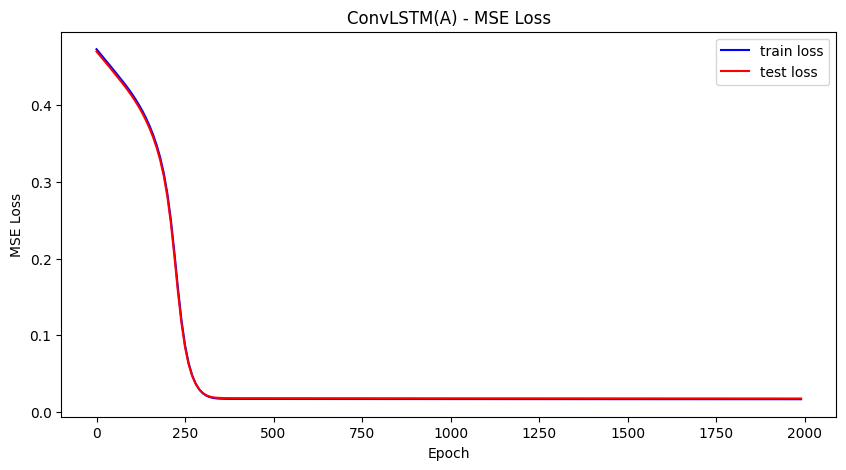

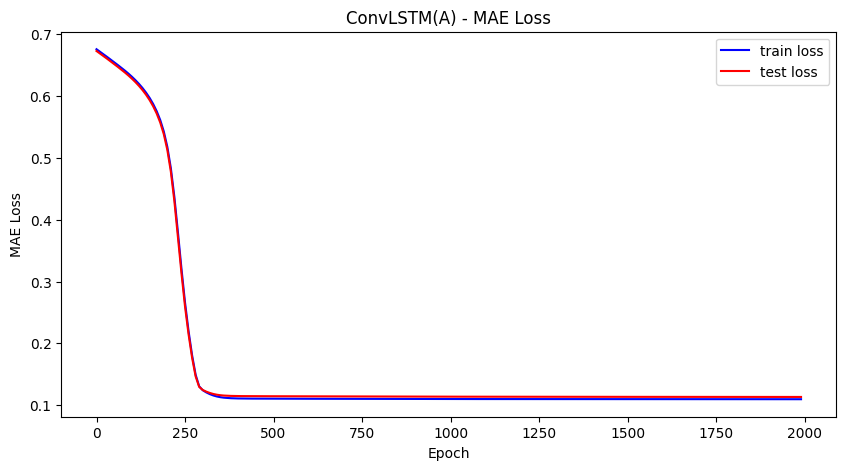

In [16]:
training_loop(2000, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test)

## predictions 

In [17]:
def inverse_scaling(y_pred, y_true, scaler):
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    y_true = scaler.inverse_transform(y_true)
    return y_pred, y_true
    

In [20]:
def make_prediction(X_scaled, y_scaled, lstm_model, scaler, in_step): # pass Original Scaled Dataset as Argument
    X_scaled, y_scaled = create_seq(X_scaled, y_scaled, in_step)
    X , y = torch.tensor(X_scaled), torch.tensor(y_scaled)
    lstm_model.eval()
    y_pred = lstm_model(X.float()) # forward pass
    y_pred = y_pred.detach().numpy()
    y_true = y.numpy()
    y_pred = np.repeat(y_pred, 7, axis = 1 )
    # inverse scaling
    y_pred, y_true = inverse_scaling(y_pred, y_true, scaler)
    return y_pred, y_true
    

In [21]:
y_pred, y_true = make_prediction(X_scaled, y_scaled, conv_lstm , mm, 3)

In [22]:
y_pred[:10]

array([59.94344 , 59.942547, 59.940582, 59.942303, 59.94256 , 59.94232 ,
       59.94351 , 59.94379 , 59.942524, 59.94261 ], dtype=float32)

In [23]:
y_true[:10].squeeze()

array([59.9 , 59.9 , 59.9 , 59.9 , 59.9 , 59.95, 59.95, 59.9 , 59.95,
       59.95])

In [24]:
'''State Dict of the Trained Model'''
for param_tensor in conv_lstm.state_dict():
    print(param_tensor, "\t", conv_lstm.state_dict()[param_tensor].size())

conv.weight 	 torch.Size([32, 3, 3])
conv.bias 	 torch.Size([32])
lstm.weight_ih_l0 	 torch.Size([128, 8])
lstm.weight_hh_l0 	 torch.Size([128, 32])
lstm.bias_ih_l0 	 torch.Size([128])
lstm.bias_hh_l0 	 torch.Size([128])
fc1.weight 	 torch.Size([10, 32])
fc1.bias 	 torch.Size([10])
fc2.weight 	 torch.Size([1, 10])
fc2.bias 	 torch.Size([1])


## graphs 

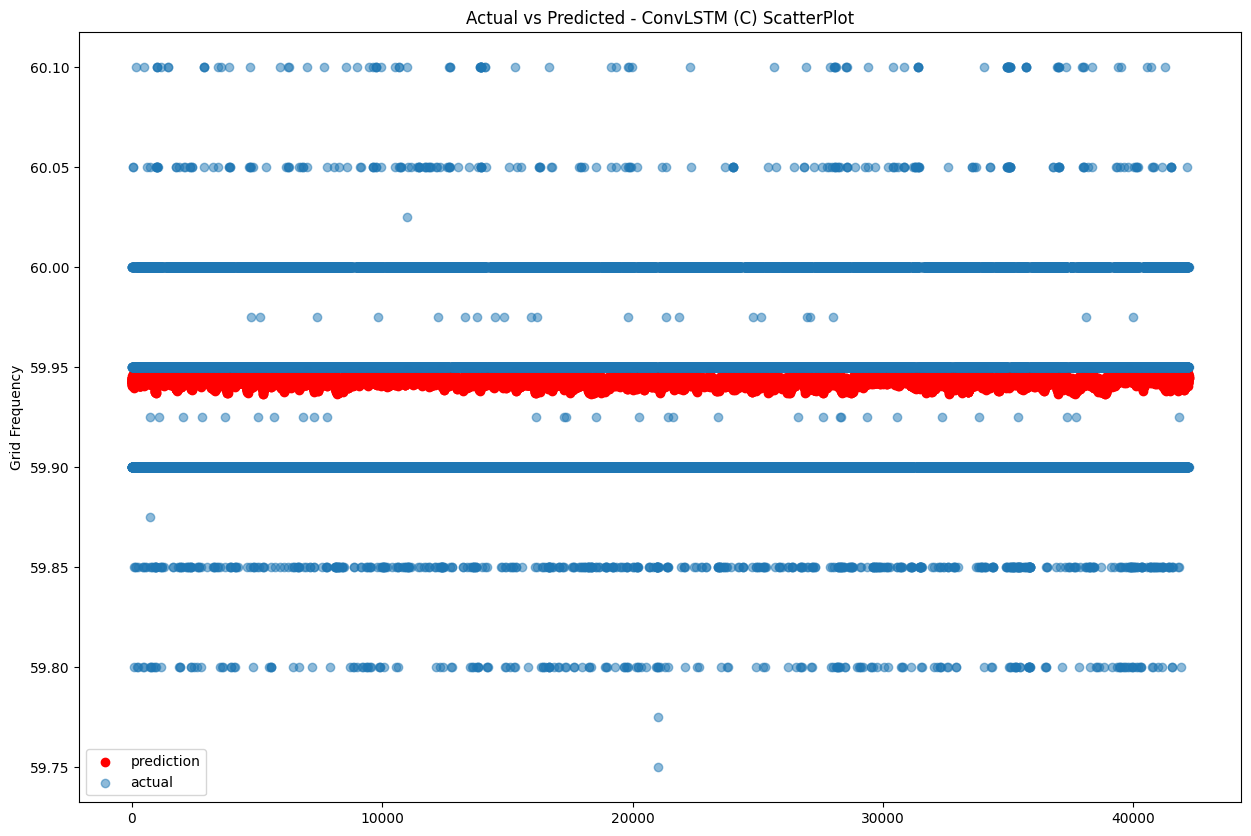

In [25]:
plt.figure(figsize = (15,10))
plt.scatter(np.arange(0,len(y_pred)),y_pred, label = 'prediction', c='r')
plt.scatter(np.arange(0,len(y_pred)),y_true.flatten(), label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (C) ScatterPlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_C - Scatter Plot.png')
plt.show()

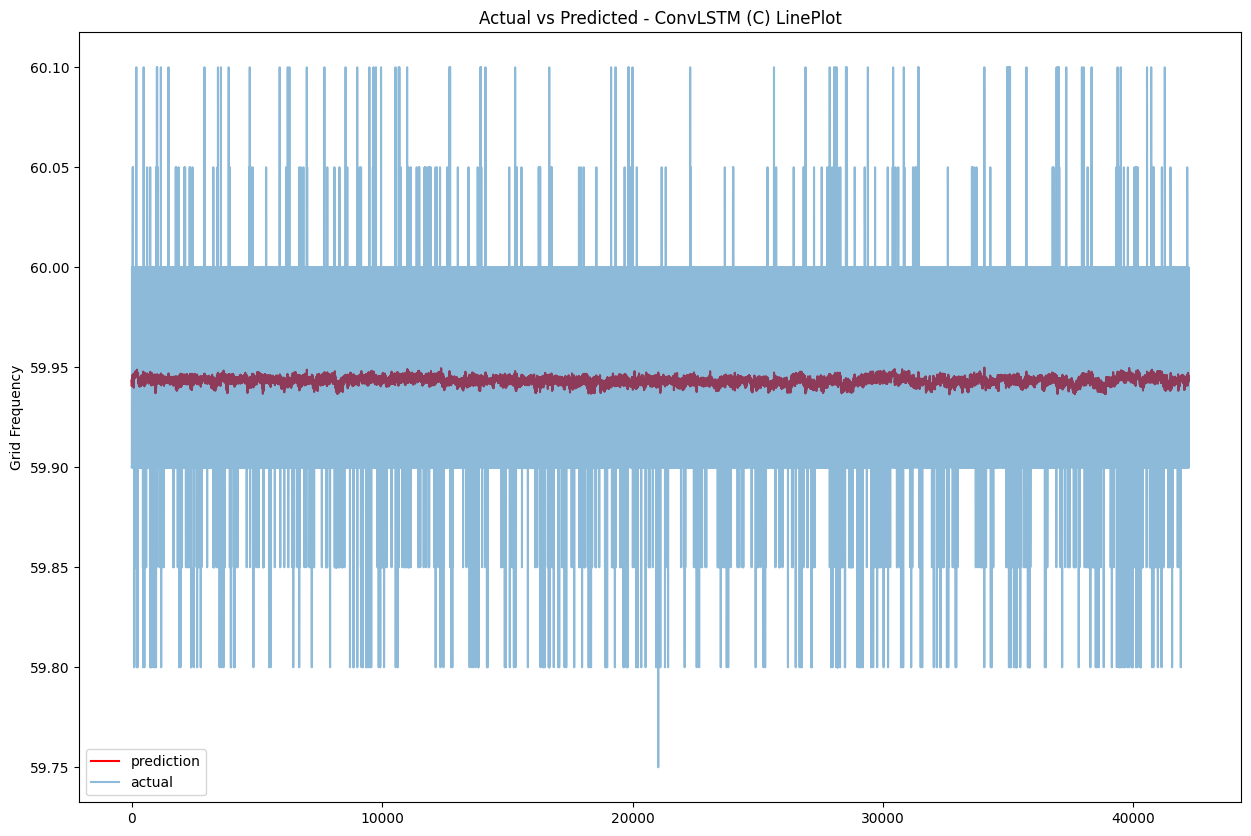

In [26]:
plt.figure(figsize = (15,10))
plt.plot(y_pred, label = 'prediction', c='r')
plt.plot(y_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (C) LinePlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_C - Line Plot.png')
plt.show()